In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Carga de archivos

try:
    df_clientes = pd.read_excel(r"Base de datos/Clientes.xlsx")
    df_productos = pd.read_excel(r"Base de datos/Productos.xlsx")
    df_ventas = pd.read_excel(r"Base de datos/Ventas.xlsx")
    df_detalle = pd.read_excel(r"Base de datos/Detalle_ventas.xlsx")
    
    print("Datos cargados exitosamente:")
    print(f"Clientes: {df_clientes.shape}")
    print(f"Productos: {df_productos.shape}")
    print(f"Ventas: {df_ventas.shape}")
    print(f"Detalle Ventas: {df_detalle.shape}")
    
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo. {e}")

Datos cargados exitosamente:
Clientes: (100, 5)
Productos: (100, 4)
Ventas: (120, 6)
Detalle Ventas: (343, 6)


In [ ]:
# Limpieza: Clientes

df_clientes['fecha_alta'] = pd.to_datetime(df_clientes['fecha_alta'])
df_clientes = df_clientes.drop_duplicates(subset=['id_cliente'], keep='first')
df_clientes['email'] = df_clientes['email'].fillna('desconocido@mail.com')
df_clientes['ciudad'] = df_clientes['ciudad'].fillna('Desconocida')

print(df_clientes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_cliente      100 non-null    int64         
 1   nombre_cliente  100 non-null    object        
 2   email           100 non-null    object        
 3   ciudad          100 non-null    object        
 4   fecha_alta      100 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 4.0+ KB
None


In [ ]:
# Limpieza: Productos

df_productos['precio_unitario'] = pd.to_numeric(df_productos['precio_unitario'], errors='coerce')
df_productos = df_productos.drop_duplicates(subset=['id_producto'], keep='first')
df_productos = df_productos.dropna(subset=['precio_unitario'])

print(df_productos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id_producto      100 non-null    int64 
 1   nombre_producto  100 non-null    object
 2   categoria        100 non-null    object
 3   precio_unitario  100 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ KB
None


In [ ]:
# Limpieza: Ventas

df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'])
df_ventas = df_ventas.drop_duplicates(subset=['id_venta'], keep='first')

# Eliminamos columnas redundantes identificadas en el README.md
df_ventas = df_ventas.drop(columns=['nombre_cliente', 'email'])
df_ventas = df_ventas.dropna(subset=['id_cliente', 'fecha'])
df_ventas['id_cliente'] = df_ventas['id_cliente'].astype(int)

print(df_ventas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_venta    120 non-null    int64         
 1   fecha       120 non-null    datetime64[ns]
 2   id_cliente  120 non-null    int64         
 3   medio_pago  120 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.9+ KB
None


In [15]:
# Limpieza: Detalle_ventas

# Eliminamos columna redundante
df_detalle = df_detalle.drop(columns=['nombre_producto'])

df_detalle['cantidad'] = pd.to_numeric(df_detalle['cantidad'], errors='coerce')
df_detalle['precio_unitario'] = pd.to_numeric(df_detalle['precio_unitario'], errors='coerce')
df_detalle['importe'] = pd.to_numeric(df_detalle['importe'], errors='coerce')

# Una venta sin importe o cantidad no sirve
df_detalle = df_detalle.dropna(subset=['id_venta', 'id_producto', 'importe', 'cantidad'])

print(df_detalle.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id_venta         343 non-null    int64
 1   id_producto      343 non-null    int64
 2   cantidad         343 non-null    int64
 3   precio_unitario  343 non-null    int64
 4   importe          343 non-null    int64
dtypes: int64(5)
memory usage: 13.5 KB
None


In [16]:
# Integridad Referencial

# 1. Ventas -> Clientes
clientes_validos = df_clientes['id_cliente'].unique()
ventas_invalidas = df_ventas[~df_ventas['id_cliente'].isin(clientes_validos)].shape[0]
print(f"Ventas con id_cliente 'huérfano': {ventas_invalidas}")
if ventas_invalidas > 0:
    df_ventas = df_ventas[df_ventas['id_cliente'].isin(clientes_validos)]

# 2. Detalle_ventas -> Ventas
ventas_validas = df_ventas['id_venta'].unique()
detalles_invalidos = df_detalle[~df_detalle['id_venta'].isin(ventas_validas)].shape[0]
print(f"Detalles con id_venta 'huérfano': {detalles_invalidos}")
if detalles_invalidos > 0:
    df_detalle = df_detalle[df_detalle['id_venta'].isin(ventas_validas)]
    
print("Verificación de integridad completada. Datos huérfanos eliminados.")

Ventas con id_cliente 'huérfano': 0
Detalles con id_venta 'huérfano': 0
Verificación de integridad completada. Datos huérfanos eliminados.


In [17]:
# Preparación de Base RFM

# 1. Calcular el valor monetario (M) por cada VENTA
df_ventas_monetario = df_detalle.groupby('id_venta')['importe'].sum().reset_index()
df_ventas_monetario = df_ventas_monetario.rename(columns={'importe': 'total_venta'})

# 2. Unir la tabla de Ventas (R y F) con la tabla de Monetario (M)
df_rfm_base = pd.merge(
    df_ventas,
    df_ventas_monetario,
    on='id_venta',
    how='inner' # Solo nos quedamos con ventas que tuvieron detalle
)

# 3. Seleccionar las columnas finales necesarias
df_rfm_base = df_rfm_base[['id_cliente', 'fecha', 'id_venta', 'total_venta']]

print(df_rfm_base.head())

# 4. Guardar la base limpia
df_rfm_base.to_csv(r'Base de datos/rfm_base_limpia.csv', index=False)

   id_cliente      fecha  id_venta  total_venta
0          62 2024-06-19         1         2902
1          49 2024-03-17         2        34186
2          20 2024-01-13         3        19558
3          36 2024-02-27         4        15966
4          56 2024-06-11         5        16360


### Analisis

In [20]:
# Cálculo de R, F y M por Cliente

# 1. Cargar la base de transacciones que limpiamos
try:
    df_base = pd.read_csv(r"Base de datos/rfm_base_limpia.csv")
    df_base['fecha'] = pd.to_datetime(df_base['fecha'])
except FileNotFoundError:
    print("Error: No se encontró 'rfm_base_limpia.csv'.")
    print("Asegúrate de ejecutar las celdas anteriores primero.")

# 2. Definir la fecha de "hoy" (snapshot)
# Usamos un día después de la última venta para que sea reproducible
snapshot_date = df_base['fecha'].max() + pd.Timedelta(days=1)
print(f"Fecha del snapshot (para calcular Recencia): {snapshot_date.date()}")

# 3. Calcular R, F y M
df_rfm = df_base.groupby('id_cliente').agg(
    Recencia=('fecha', lambda x: (snapshot_date - x.max()).days),
    Frecuencia=('id_venta', 'count'),
    Monetario=('total_venta', 'sum')
).reset_index()

print("\nTabla RFM por cliente")
print(df_rfm.head())

# Asegurarse de que los tipos de datos son correctos
df_rfm['Recencia'] = df_rfm['Recencia'].astype(int)
df_rfm['Frecuencia'] = df_rfm['Frecuencia'].astype(int)
df_rfm['Monetario'] = df_rfm['Monetario'].astype(float)

Fecha del snapshot (para calcular Recencia): 2024-06-29

Tabla RFM por cliente
   id_cliente  Recencia  Frecuencia  Monetario
0           1        95           2      72448
1           2        78           1      22150
2           3       134           1      33310
3           5         4           4     132158
4           6       137           2      48878


In [21]:
# 1. Estadísticas Básicas

print("--- Estadísticas Descriptivas de RFM ---")
# .describe() nos da la media, mediana (50%), min, max, y cuartiles
print(df_rfm[['Recencia', 'Frecuencia', 'Monetario']].describe())

--- Estadísticas Descriptivas de RFM ---
         Recencia  Frecuencia      Monetario
count   67.000000   67.000000      67.000000
mean    75.940299    1.791045   39573.388060
std     52.826727    0.946081   23945.209866
min      1.000000    1.000000    4283.000000
25%     26.000000    1.000000   21554.500000
50%     72.000000    2.000000   34326.000000
75%    120.500000    2.000000   55557.500000
max    172.000000    5.000000  132158.000000


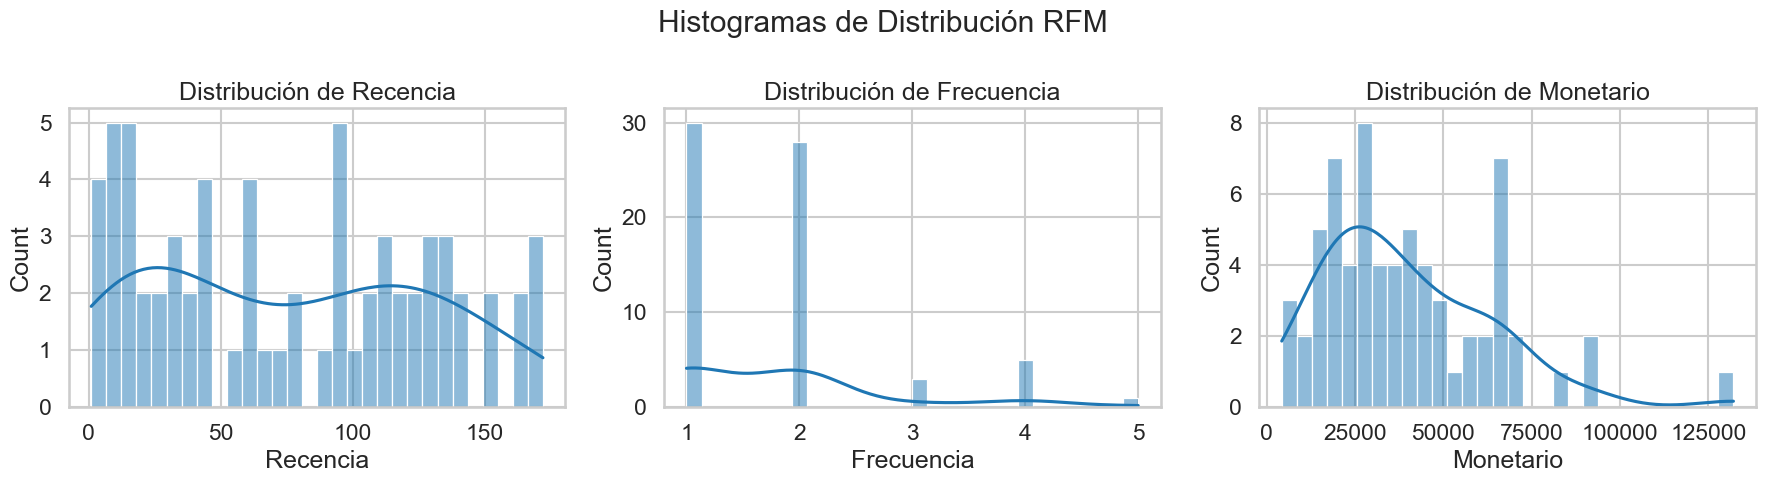

In [24]:
# 2. Tipo de Distribución

# Crear una figura con 3 sub-gráficos (uno para R, uno para F, uno para M)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Histogramas de Distribución RFM')

# Gráfico de Recencia
sns.histplot(df_rfm['Recencia'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Distribución de Recencia')

# Gráfico de Frecuencia
sns.histplot(df_rfm['Frecuencia'], bins=30, ax=axes[1], kde=True)
axes[1].set_title('Distribución de Frecuencia')

# Gráfico de Monetario
sns.histplot(df_rfm['Monetario'], bins=30, ax=axes[2], kde=True)
axes[2].set_title('Distribución de Monetario')

plt.tight_layout()
plt.show()

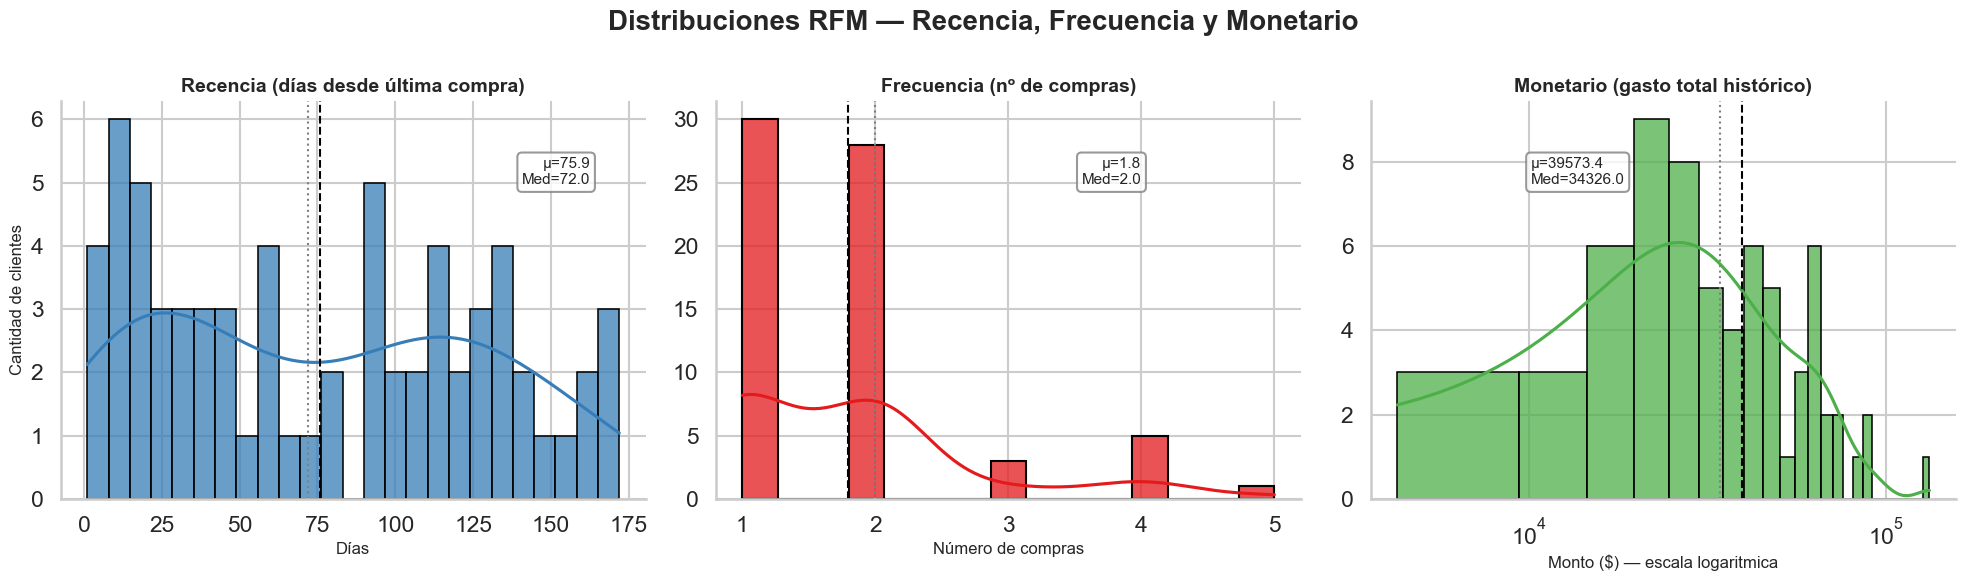

In [25]:
# Mejoras visuales para los histogramas RFM

sns.set_style("whitegrid")
sns.set_context("talk")
palette = ['#377eb8', '#e41a1c', '#4daf4a']  # azul, rojo, verde
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribuciones RFM — Recencia, Frecuencia y Monetario', fontsize=20, weight='bold')
fig.subplots_adjust(top=0.88, wspace=0.3)

# Helper para dibujar media/mediana
def _annotate_stats(ax, data, xpos='right'):
    mean = data.mean()
    median = data.median()
    ymax = ax.get_ylim()[1]
    ax.axvline(mean, color='k', linestyle='--', linewidth=1.5, label=f"Media: {mean:.1f}")
    ax.axvline(median, color='gray', linestyle=':', linewidth=1.5, label=f"Mediana: {median:.1f}")
    # Anotaciones
    x_text = data.quantile(0.95) if xpos == 'right' else data.quantile(0.05)
    ax.text(x_text, ymax*0.82, f"μ={mean:.1f}\nMed={median:.1f}", 
            ha='right' if xpos == 'right' else 'left', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8), fontsize=11)

# Recencia
sns.histplot(df_rfm['Recencia'], bins=25, kde=True, color=palette[0], alpha=0.75, edgecolor='k', ax=axes[0])
axes[0].set_title('Recencia (días desde última compra)', fontsize=14, weight='semibold')
axes[0].set_xlabel('Días', fontsize=12)
axes[0].set_ylabel('Cantidad de clientes', fontsize=12)
_annotate_stats(axes[0], df_rfm['Recencia'], xpos='right')
sns.despine(ax=axes[0])

# Frecuencia
sns.histplot(df_rfm['Frecuencia'], bins=15, kde=True, color=palette[1], alpha=0.75, edgecolor='k', ax=axes[1])
axes[1].set_title('Frecuencia (nº de compras)', fontsize=14, weight='semibold')
axes[1].set_xlabel('Número de compras', fontsize=12)
axes[1].set_ylabel('')
_annotate_stats(axes[1], df_rfm['Frecuencia'], xpos='right')
sns.despine(ax=axes[1])

# Monetario (escala log para facilitar interpretación si hay sesgo)
sns.histplot(df_rfm['Monetario'], bins=25, kde=True, color=palette[2], alpha=0.75, edgecolor='k', ax=axes[2])
axes[2].set_title('Monetario (gasto total histórico)', fontsize=14, weight='semibold')
axes[2].set_xlabel('Monto ($)', fontsize=12)
axes[2].set_ylabel('')
# Usar escala log si la distribución está muy sesgada
try:
    axes[2].set_xscale('log')
    axes[2].set_xlabel('Monto ($) — escala logaritmica', fontsize=12)
except Exception:
    pass
_annotate_stats(axes[2], df_rfm['Monetario'], xpos='left')
sns.despine(ax=axes[2])

plt.tight_layout()
plt.show()

            Recencia  Frecuencia  Monetario
Recencia    1.000000   -0.408915  -0.334218
Frecuencia -0.408915    1.000000   0.651873
Monetario  -0.334218    0.651873   1.000000


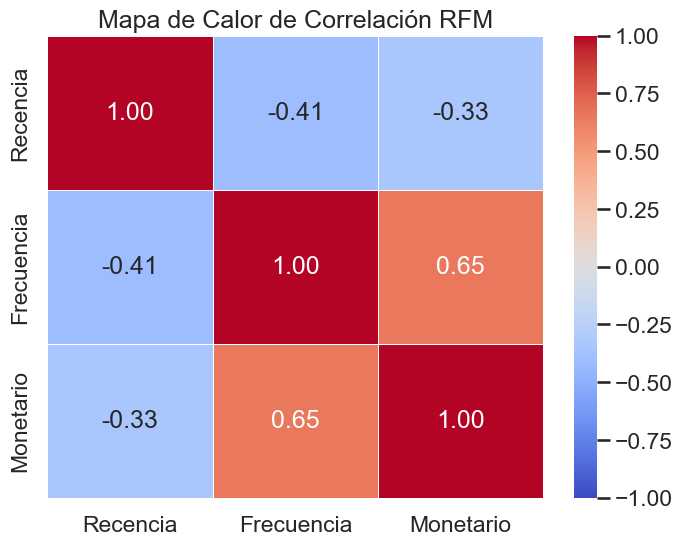

In [26]:
# 3. Correlaciones

# Calcular la matriz de correlación
corr_matrix = df_rfm[['Recencia', 'Frecuencia', 'Monetario']].corr()

print(corr_matrix)

# Visualizar la matriz con un mapa de calor (heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=0.5, vmin=-1, vmax=1)

plt.title('Mapa de Calor de Correlación RFM')
plt.show()


--- Visualización de Outliers (Boxplots) ---


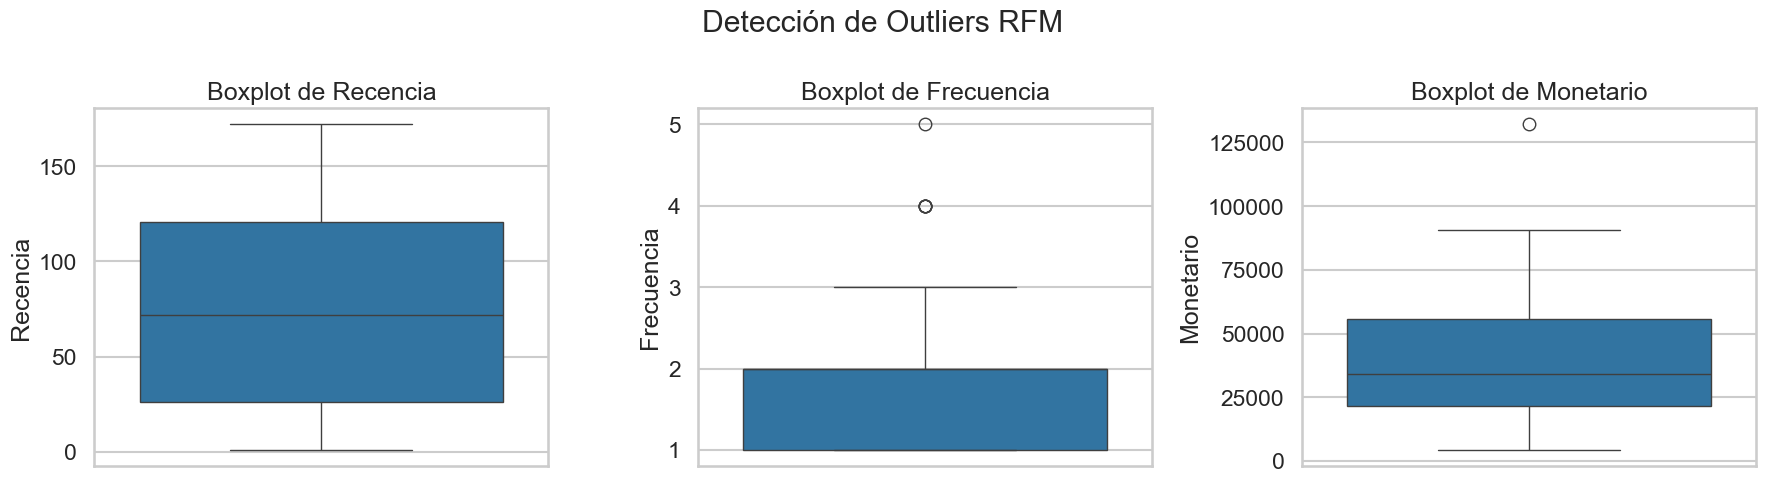

In [27]:
# 4. Análisis de Outliers
print("\n--- Visualización de Outliers (Boxplots) ---")

# Crear una figura con 3 sub-gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Detección de Outliers RFM')

# Boxplot de Recencia
sns.boxplot(y=df_rfm['Recencia'], ax=axes[0])
axes[0].set_title('Boxplot de Recencia')

# Boxplot de Frecuencia
sns.boxplot(y=df_rfm['Frecuencia'], ax=axes[1])
axes[1].set_title('Boxplot de Frecuencia')

# Boxplot de Monetario
sns.boxplot(y=df_rfm['Monetario'], ax=axes[2])
axes[2].set_title('Boxplot de Monetario')

plt.tight_layout()
plt.show()

### Interpretacion de Resultados

In [28]:
# 1. Enriquecer df_rfm con 'ciudad'

# Hacemos un merge para agregar la 'ciudad' a la tabla RFM
df_rfm_enriquecido = pd.merge(
    df_rfm,
    df_clientes[['id_cliente', 'ciudad']], # Solo traemos las columnas que necesitamos
    on='id_cliente',
    how='left' # Queremos mantener a todos los clientes de df_rfm
)

print("\nTabla RFM enriquecida con 'ciudad'")
print(df_rfm_enriquecido.head())


Tabla RFM enriquecida con 'ciudad'
   id_cliente  Recencia  Frecuencia  Monetario       ciudad
0           1        95           2    72448.0   Carlos Paz
1           2        78           1    22150.0   Carlos Paz
2           3       134           1    33310.0   Rio Cuarto
3           5         4           4   132158.0      Cordoba
4           6       137           2    48878.0  Villa Maria


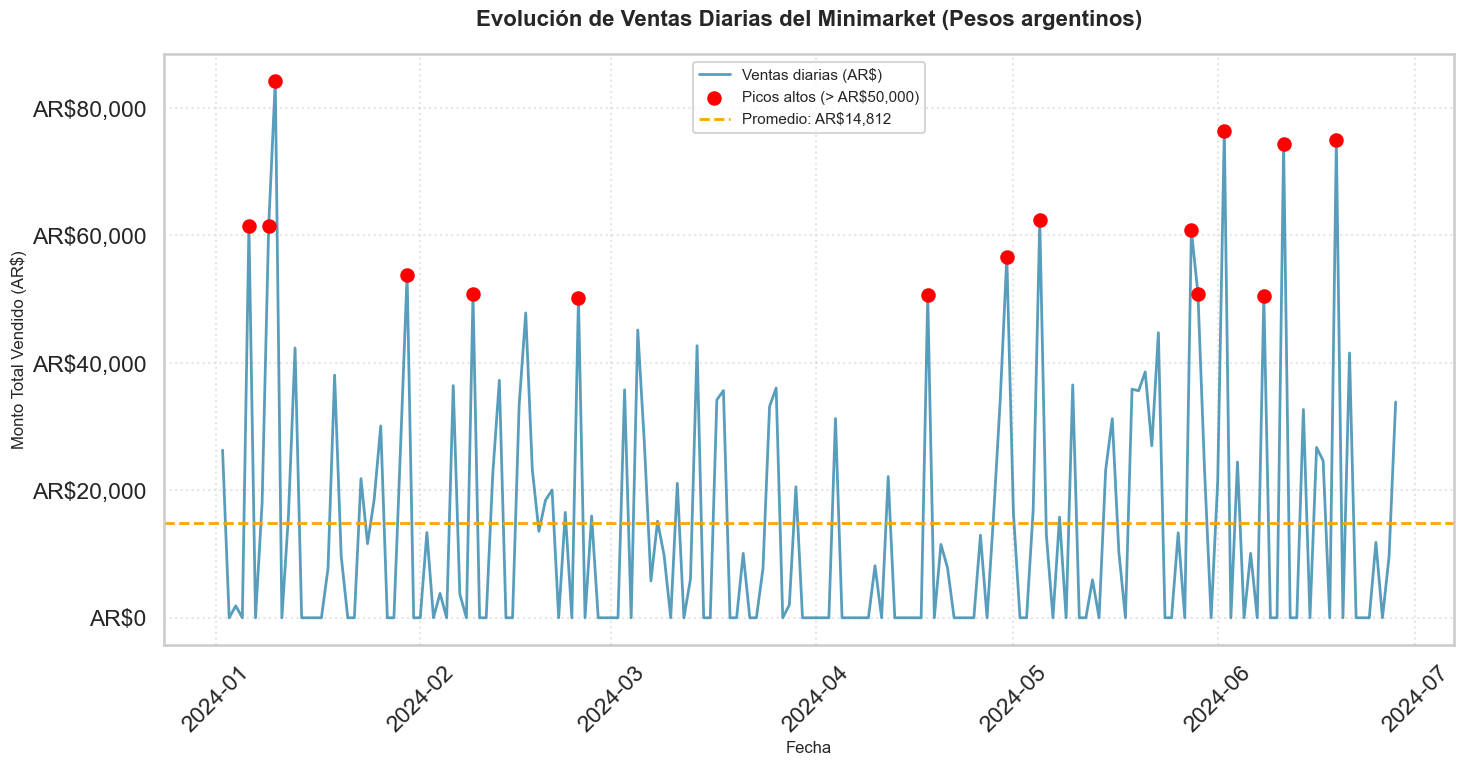

In [39]:
# 2.1 Visualización: Ventas a lo largo del Tiempo (moneda: pesos argentinos - AR$)

df_ventas_diarias = df_base.set_index('fecha').resample('D')['total_venta'].sum().reset_index()

plt.figure(figsize=(15, 8))
plt.plot(df_ventas_diarias['fecha'], df_ventas_diarias['total_venta'],
         linewidth=2, color='#2E86AB', alpha=0.8, label='Ventas diarias (AR$)')

# Resaltar los picos más altos (umbral en AR$)
umbral = 50000
picos_altos = df_ventas_diarias[df_ventas_diarias['total_venta'] > umbral]
plt.scatter(picos_altos['fecha'], picos_altos['total_venta'],
            color='red', s=80, zorder=5, label=f'Picos altos (> AR${umbral:,.0f})')

# Añadir línea de promedio
promedio = df_ventas_diarias['total_venta'].mean()
plt.axhline(y=promedio, color='orange', linestyle='--', linewidth=2,
           label=f'Promedio: AR${promedio:,.0f}')

plt.title('Evolución de Ventas Diarias del Minimarket (Pesos argentinos)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Monto Total Vendido (AR$)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(fontsize=11)

# Formatear el eje Y para mostrar AR$ y separador de miles
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'AR${x:,.0f}'))

# Rotar fechas para mejor legibilidad
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_23924\1704751343.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_gasto_ciudad, x='ciudad', y='Monetario', palette='viridis')


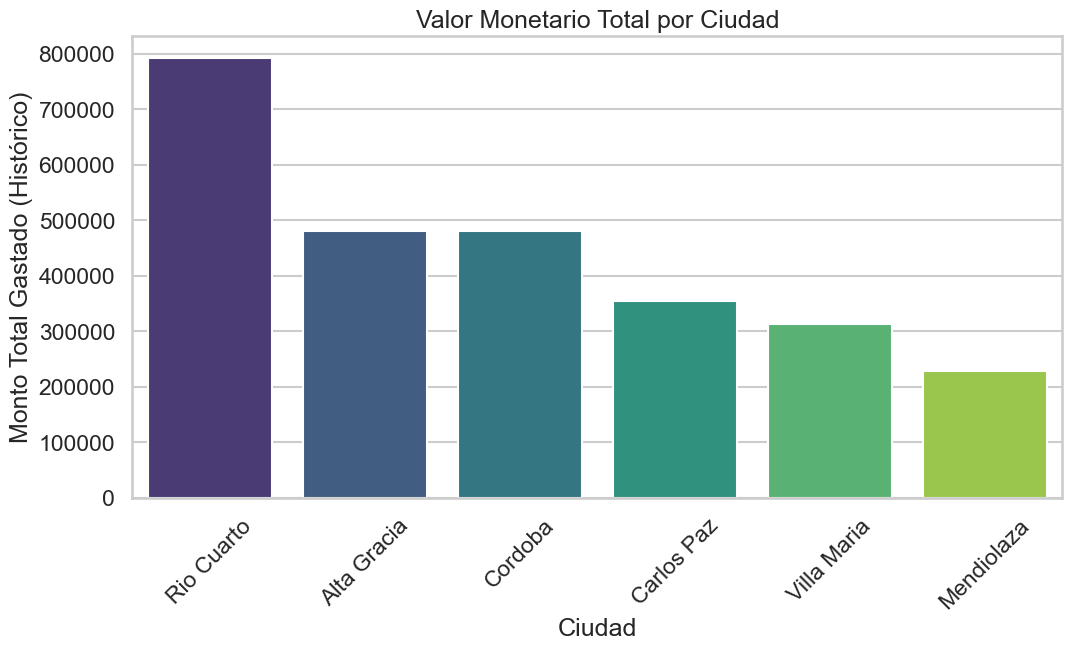

In [37]:
# 2.2 Visualización: Gasto Total por Ciudad

# Agrupamos por ciudad y sumamos el valor Monetario
df_gasto_ciudad = df_rfm_enriquecido.groupby('ciudad')['Monetario'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_gasto_ciudad, x='ciudad', y='Monetario', palette='viridis')

plt.title('Valor Monetario Total por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Monto Total Gastado (Histórico)')
plt.xticks(rotation=45)
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_23924\2577779646.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_ventas, x='medio_pago', order=df_ventas['medio_pago'].value_counts().index, palette='Blues_r')


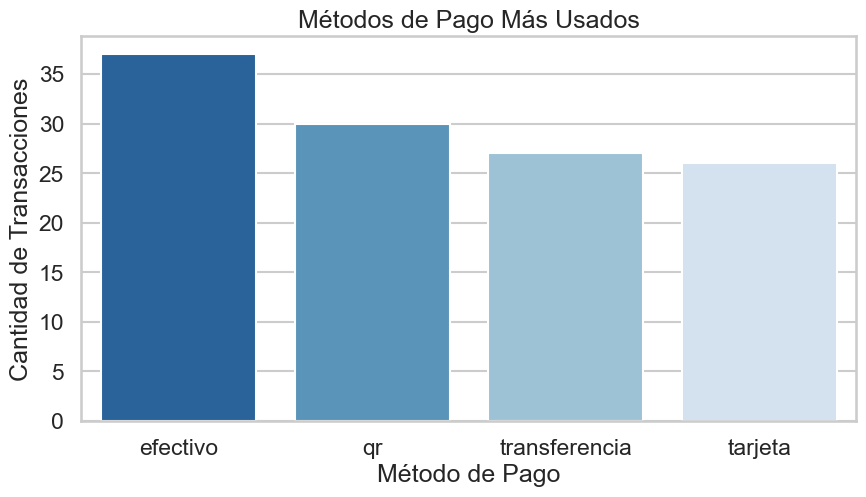

In [38]:
# 2.3 Visualización: Frecuencia de Métodos de Pago

plt.figure(figsize=(10, 5))
sns.countplot(data=df_ventas, x='medio_pago', order=df_ventas['medio_pago'].value_counts().index, palette='Blues_r')

plt.title('Métodos de Pago Más Usados')
plt.xlabel('Método de Pago')
plt.ylabel('Cantidad de Transacciones')
plt.show()